In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Le but est ici de construire un simple modèle de neurones qui teste l'idée d'utiliser des délais synaptiques pour améliorer la détection de patterns dans le signal en créant une synchronie.


# generating a synthetic input with an activity dependent delay

In [2]:
import LSD

In [3]:
%whos

Variable   Type      Data/Info
------------------------------
LSD        module    <module 'LSD' from '/User<...>cDelays/LSD/__init__.py'>


## tuning curves on circular space: von Mises + latency code

In [4]:
from LSD.tuning import *

In [5]:
%whos

Variable             Type        Data/Info
------------------------------------------
A_true               float       1.5
B_true               float       0.5
LSD                  module      <module 'LSD' from '/User<...>cDelays/LSD/__init__.py'>
N_inputs             int         180
N_scan               int         5
N_starts             float       80.0
NumpyRNG             type        <class 'pyNN.random.NumpyRNG'>
RandomDistribution   type        <class 'pyNN.random.RandomDistribution'>
celebrini            function    <function celebrini at 0x2555fb0d0>
delay_0              float       25.0
delay_min            float       1.0
dt                   float       0.5
figsize              tuple       n=2
get_latency          function    <function get_latency at 0x2555eaf70>
inh_gain             float       1.0
init_logging         function    <function init_logging at 0x2555e1a60>
lambda_n             float       10.0
np                   module      <module 'numpy' from '/us<...>kage

# feeding the input to a range of cells

We modelize a very generic feed-forward network with arbitrary weights and delays:

In [6]:
%%writefile LSD/model.py

from .__init__ import *
from LSD.tuning import *
from LSD.plot import plot_spiketrains, histogram, color

def LSD_neuron(weights, delays, t_starts=t_starts, inh_gain=inh_gain, 
               lambda_n=lambda_n, B_true=B_true, do_COBA=False, 
               fig=None, ax=None, sat=1, alpha=1, verbose=False):

    # === Build the network ========================================================
    sim.setup(timestep=dt)
    spike_source = celebrini(N_inputs, B=B_true, t_starts=t_starts, verbose=False) # les neurones qui envoient des spikes 
    spike_input = sim.Population(N_inputs, spike_source)
    spike_input.record('spikes')
    
    noise_E = sim.Population(N_inputs, sim.SpikeSourcePoisson(rate=lambda_n, duration=simtime), label="expoisson")        
    noise_E.record('spikes')
    
    noise_I = sim.Population(N_inputs, sim.SpikeSourcePoisson(rate=lambda_n, duration=simtime), label="inpoisson")        
    noise_I.record('spikes')
    
    ###---CELL PARAMETERS-------------------------------------------------------------------------------
    if do_COBA:
        # from https://github.com/NeuralEnsemble/PyNN/blob/adb4ffc70de204a0c6aca792daf5c91b4240af1f/pyNN/standardmodels/cells.py#L165
        cell_pars =  {
                'v_rest':   -65.0,  # Resting membrane potential in mV.
                'cm':         1.0,  # Capacity of the membrane in nF
                'tau_m':     20.0,  # Membrane time constant in ms.
                'tau_refrac': 0.1,  # Duration of refractory period in ms.
                'tau_syn_E':  5.0,  # Decay time of the excitatory synaptic conductance in ms.
                'tau_syn_I':  5.0,  # Decay time of the inhibitory synaptic conductance in ms.
                'e_rev_E':    0.0,  # Reversal potential for excitatory input in mV
                'e_rev_I':  -70.0,  # Reversal potential for inhibitory input in mV
                'v_thresh': -50.0,  # Spike threshold in mV.
                'v_reset':  -65.0,  # Reset potential after a spike in mV.
                'i_offset':   0.0,  # Offset current in nA
                }
        cell = sim.IF_cond_exp
    else:
        cell_pars =  {'cm': 1.0, 'i_offset': 0.0, 'tau_m': 20.0, 'tau_refrac': 0.1, 'tau_syn_E': 5.0, 'tau_syn_I': 5.0, 'v_reset': -65.0, 'v_rest': -65.0, 'v_thresh': -50.0}
        cell = sim.IF_curr_exp
    tc_cells = sim.Population(N_inputs, cell, cell_pars, label='tc_cells')
    tc_cells.record('spikes')

    #Synapses type
    delayed_synapses = sim.StaticSynapse()
    #connectivity using the projection method
    weights_E = weights*(weights>0) # TODO a more general model could receive E and I input on the same synapse
    weights_I = inh_gain*weights*(weights<0)
    if do_COBA: weights_I *= -1 # weights are always positive in a COBA model, see http://neuralensemble.org/docs/PyNN/connections.html?highlight=inhibitory#fixed-synaptic-weight
    
    connections_E = sim.Projection(spike_input, tc_cells,
                                        connector=sim.AllToAllConnector(),
                                        synapse_type=delayed_synapses,
                                        receptor_type='excitatory',
                                        label="excitatory connections")

    connections_E.set(weight=weights_E, delay=delays)
    
    connections_I = sim.Projection(spike_input, tc_cells,
                                        connector=sim.AllToAllConnector(),
                                        synapse_type=delayed_synapses,
                                        receptor_type='inhibitory',
                                        label="inhibitory connections")

    connections_I.set(weight=weights_I, delay=delays)

    connections_noise_E = sim.Projection(noise_E, tc_cells,
                                         connector=sim.AllToAllConnector(),
                                         synapse_type=delayed_synapses,
                                         receptor_type='excitatory',
                                         label="excitatory connections")

    connections_noise_E.set(weight=weights_E, delay=delays)

    
    connections_noise_I = sim.Projection(noise_I, tc_cells,
                                         connector=sim.AllToAllConnector(),
                                         synapse_type=delayed_synapses,
                                         receptor_type='inhibitory',
                                         label="inhibitory connections")
    connections_noise_I.set(weight=weights_I, delay=delays)

    # === Run simulation ===========================================================
    sim.run(simtime)
    sim.end()
    
    # === Doing the plots ===========================================================
    if fig is None:
        fig, ax = plt.subplots(figsize = figsize)
    if ax is None:
        ax = fig.subplot(1, 1)
    sts_noise_E = noise_E.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(sts_noise_E, color=color(0, sat), simtime=simtime, simtime_show=simtime_show, fig=fig, ax=ax, alpha=alpha)
    sts_noise_I = noise_I.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(sts_noise_I, color=color(0, sat), marker='.', simtime=simtime, simtime_show=simtime_show, fig=fig, ax=ax, alpha=alpha)

    sts_in = spike_input.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(sts_in, color=color(1, sat), simtime=simtime, simtime_show=simtime_show, fig=fig, ax=ax, alpha=alpha)
    if verbose: print('sts_in', [list(st.as_array()) for st in sts_in])
    
    sts_out = tc_cells.get_data().segments[0].spiketrains
    if verbose: print('sts_out', [list(st.as_array()) for st in sts_out])
    fig, ax = plot_spiketrains(sts_out, color=color(2, sat), simtime=simtime, simtime_show=simtime_show, fig=fig, ax=ax, alpha=alpha)
    
    return fig, ax, locals()

Overwriting LSD/model.py


Object `IF_cond_exp` not found.


# Testing a uniform one-to-one connectivity

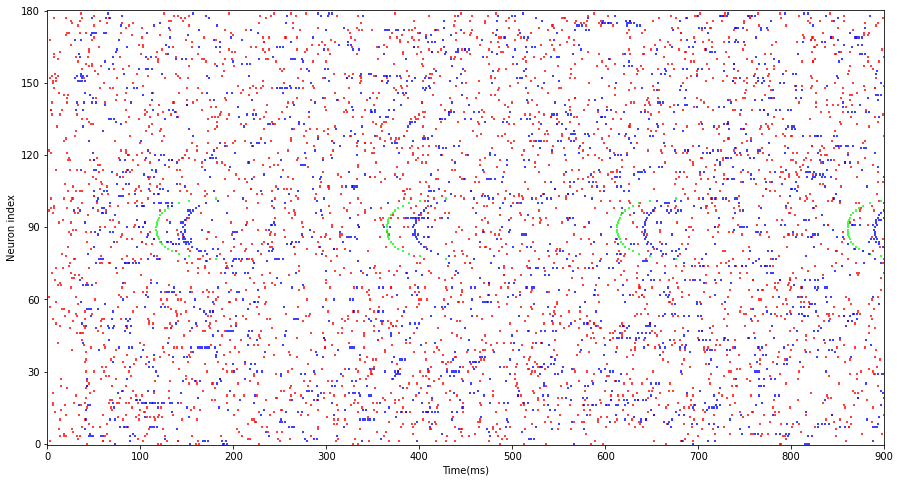

In [7]:
from LSD.model import LSD_neuron

def one_to_one(weight_0, delay_0):
    weights = np.diag(np.ones(N_inputs))
    weights /= weights.sum(axis=0)
    weights -= weights.mean(axis=0)

    weights *= weight_0

    delays = delay_0 * np.ones((N_inputs, N_inputs)) #np.diag(np.ones(N_inputs))
    
    return weights, delays

weights, delays = one_to_one(weight_0, delay_0)

fig, ax, output = LSD_neuron(weights, delays, verbose=0)

## Testing different base weights

weight_0_=5.000
weight_0_=7.071
weight_0_=10.000
weight_0_=14.142
weight_0_=20.000


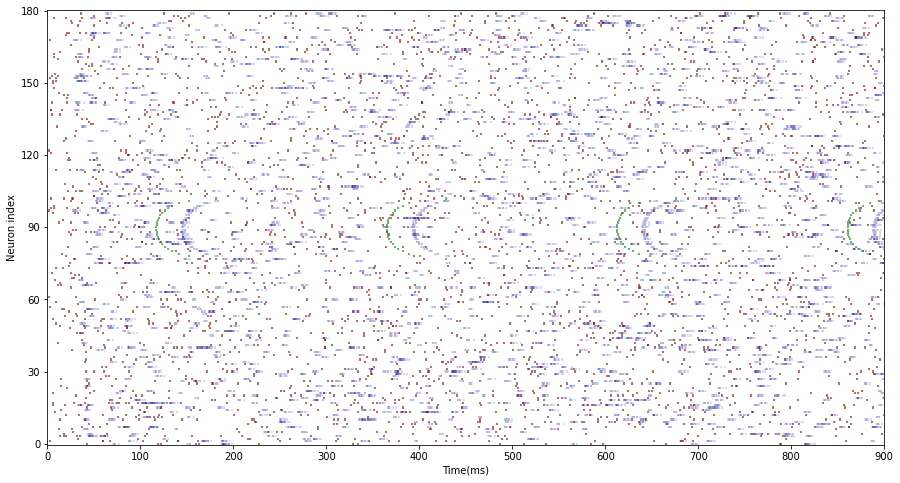

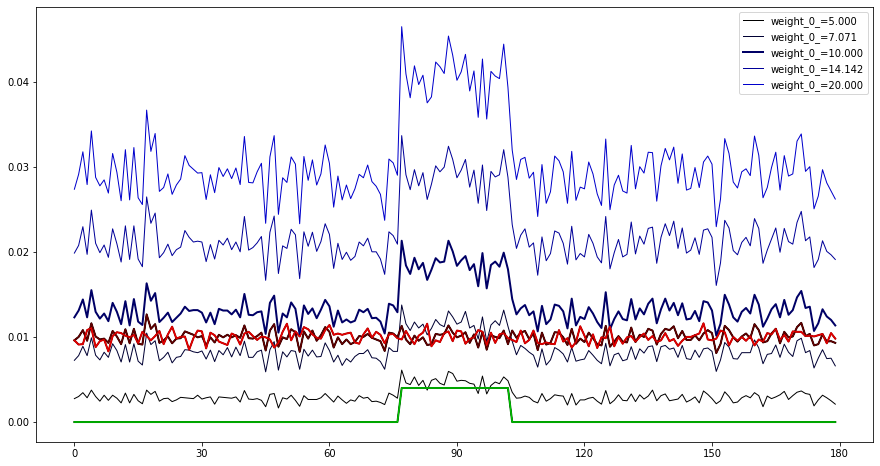

In [8]:
from LSD.plot import plot_spiketrains, histogram
fig, ax = plt.subplots(figsize=figsize)
hfig, hax = plt.subplots(figsize=figsize)
for i_scan, weight_0_ in enumerate(weight_0*np.logspace(-1, 1, N_scan, base=2, endpoint=True)):
    label = f'{weight_0_=:.3f}'
    print(label)
    weights, delays = one_to_one(weight_0_, delay_0)
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan, alpha=1/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    

## Testing different inhibitory gains

inh_gain_=0.500
inh_gain_=0.707
inh_gain_=1.000
inh_gain_=1.414
inh_gain_=2.000


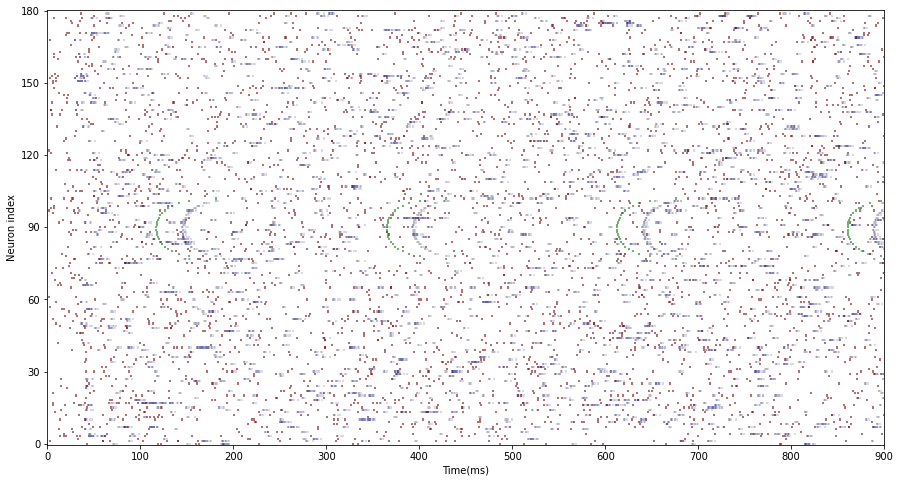

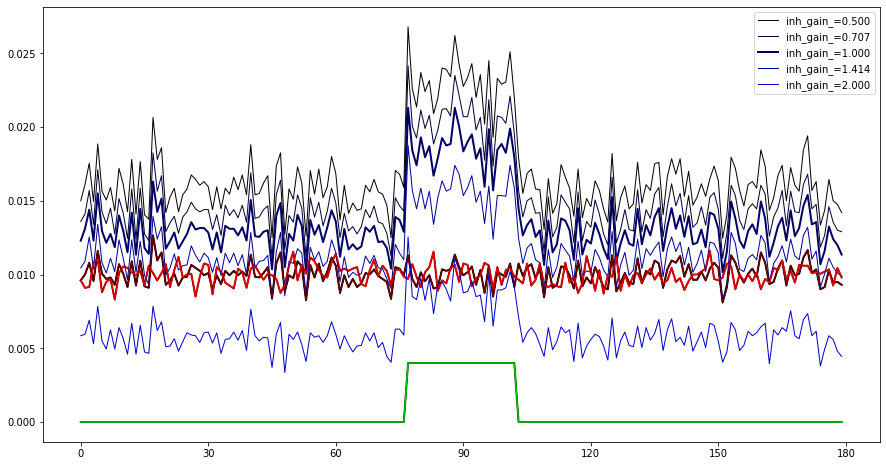

In [9]:
from LSD.plot import plot_spiketrains, histogram
fig, ax = plt.subplots(figsize=figsize)
hfig, hax = plt.subplots(figsize=figsize)
for i_scan, inh_gain_ in enumerate(inh_gain*np.logspace(-1, 1, N_scan, base=2, endpoint=True)):
    label = f'{inh_gain_=:.3f}'
    print(label)
    weights, delays = one_to_one(weight_0, delay_0)
    fig, ax, output = LSD_neuron(weights, delays, inh_gain=inh_gain_, fig=fig, ax=ax, sat=i_scan/N_scan, alpha=1/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    

## Testing different delays

delay_0_=12.500
delay_0_=17.678
delay_0_=25.000
delay_0_=35.355
delay_0_=50.000


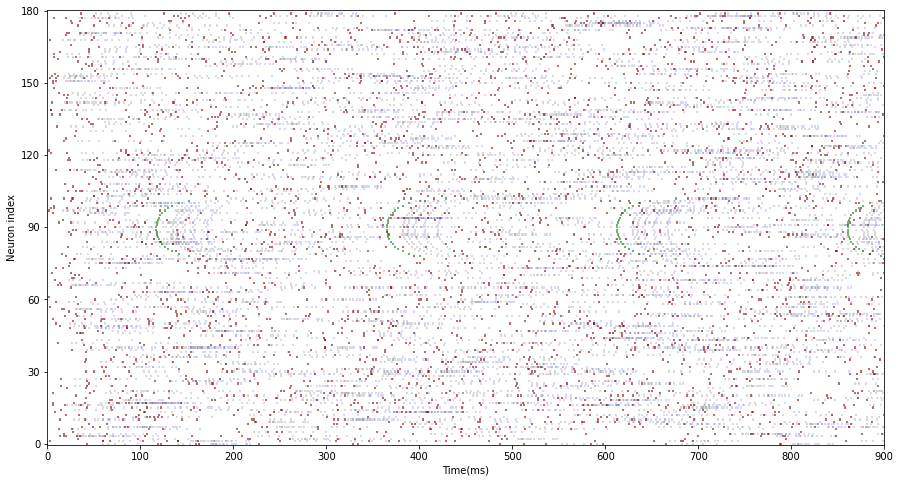

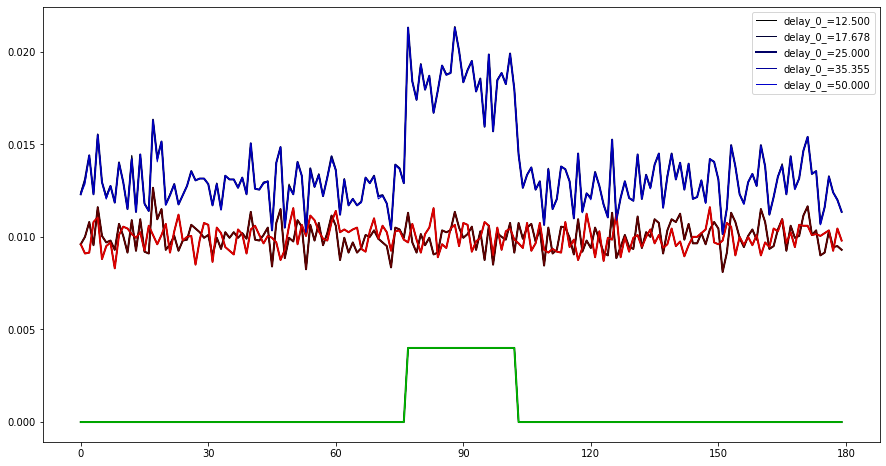

In [10]:
fig, ax = plt.subplots(figsize=figsize)
hfig, hax = plt.subplots(figsize=figsize)
for i_scan, delay_0_ in enumerate(delay_0*np.logspace(-1, 1, N_scan, base=2)):
    label = f'{delay_0_=:.3f}'
    print(label)
    weights, delays = one_to_one(weight_0, delay_0_)
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan, alpha=1/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');      

DONE: undestood why the whole input raster also moves = one has to set weights to the projection object not to the synapses

# Testing different tuning curves on the weights (with fixed synaptic delays)

using https://fr.wikipedia.org/wiki/Matrice_de_Toeplitz 

## Testing different base weights:

In [11]:
from scipy.linalg import toeplitz

def tuned(weight_0, delay_0, B=B_true):
    tf = vonmises(N_inputs, theta=.0, B=B)
    tf /= tf.sum()
    tf -= tf.mean()
    
    weights = weight_0_ * toeplitz(tf)
    delays = delay_0 * np.ones((N_inputs, N_inputs))    
    return weights, delays

weight_0_=5.000
weight_0_=7.071
weight_0_=10.000
weight_0_=14.142
weight_0_=20.000


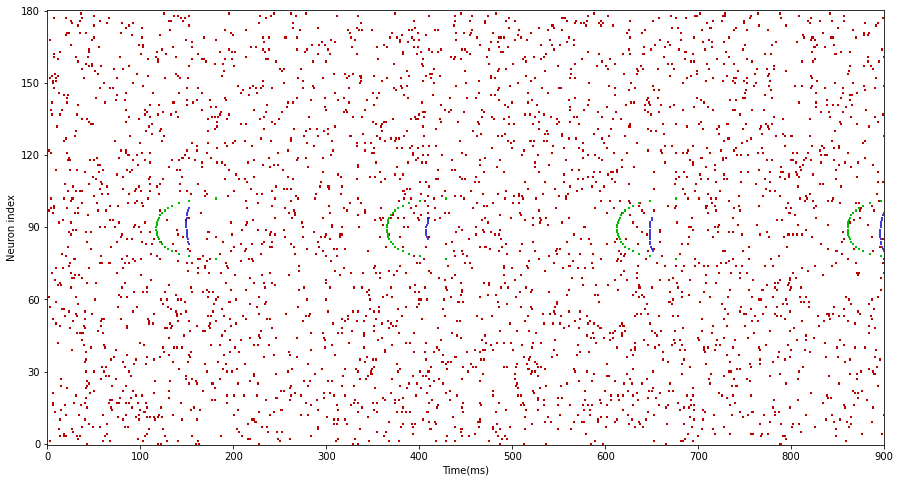

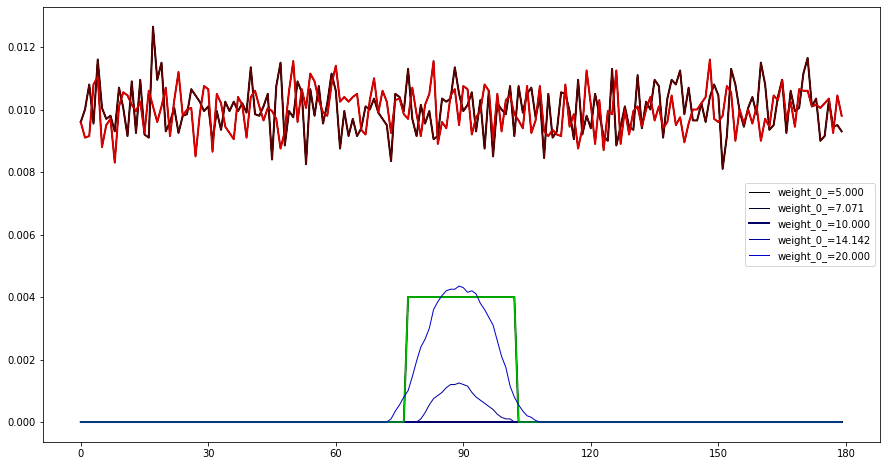

In [12]:
fig, ax = plt.subplots(figsize=figsize)
hfig, hax = plt.subplots(figsize=figsize)

for i_scan, weight_0_ in enumerate(weight_0*np.logspace(-1, 1, N_scan, base=2)):
    label = f'{weight_0_=:.3f}'
    print(label)
    weights, delays = tuned(weight_0_, delay_0)
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan, alpha=1)#/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='right');   

## Testing different tuning bandwidths:

B_=0.250
B_=0.354
B_=0.500
B_=0.707
B_=1.000


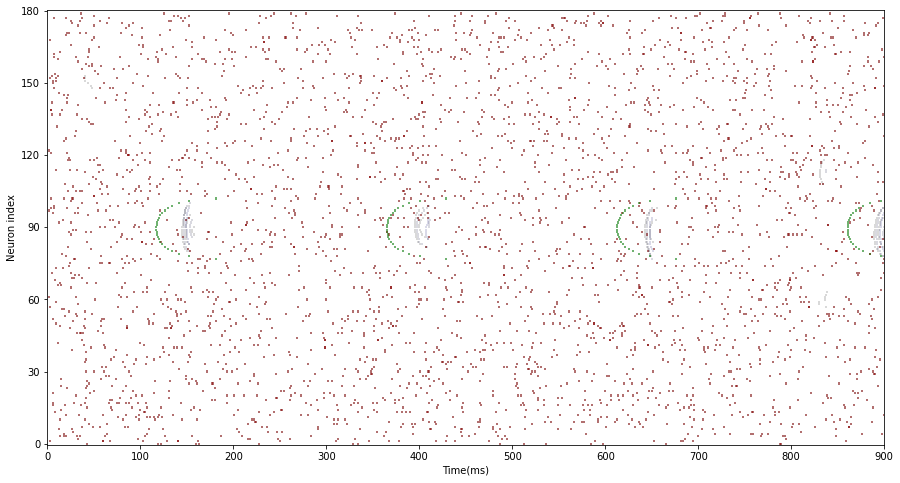

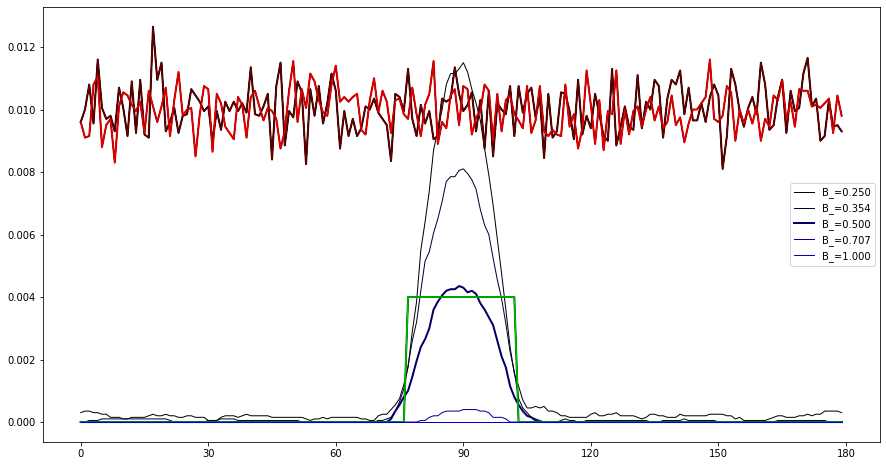

In [13]:
fig, ax = plt.subplots(figsize=figsize)
hfig, hax = plt.subplots(figsize=figsize)
for i_scan, B_ in enumerate(B_true*np.logspace(-1, 1, N_scan, base=2)):
    label = f'{B_=:.3f}'
    print(label)

    weights, delays = tuned(weight_0, delay_0, B=B_)
    
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan, alpha=1/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    

# Testing different tuning curves on the weights and delays

## estimating the best timings

Building a function that computes the optimal delays to create a synchronization :

In [14]:
A_est = A_true
B_est = B_true
tau_est = tau

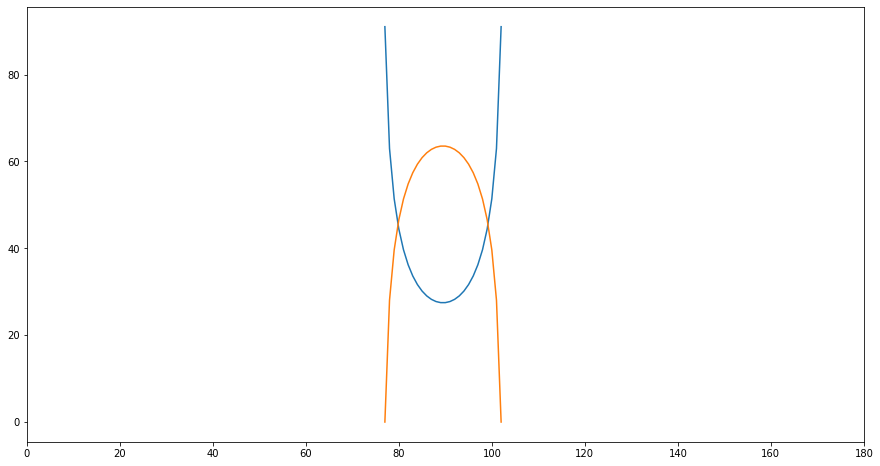

In [15]:
def get_delay_line(N_inputs, A=A_est, B=B_est, tau_est=tau_est, theta=0.):
    current = A * vonmises(N_inputs, theta=theta, B=B)
    spike_times = get_latency(None, current, tau=tau_est, t_start=0.)
    spike_times = np.array([lat[0] if len(lat)>0 else np.nan for lat in spike_times])
    tau_max = np.nanmax(spike_times)
    delay_line = tau_max - spike_times
    return delay_line

if 1:
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    current = A_est * vonmises(N_inputs, theta=1/2, B=B_est)
    spike_times = get_latency(None, current, tau=tau_est, t_start=0.)
    spike_times = np.array([lat[0] if len(lat)>0 else np.nan for lat in spike_times])
    ax.plot(spike_times, label='spike times')
    ax.plot(get_delay_line(N_inputs, theta=1/2),label='hetero synaptic delays')
    ax.set_xlim(0, N_inputs)


## adding hetero-synaptic delays and testing without noise

In [16]:
from scipy.linalg import toeplitz
delay_min = 1
def tuned_delays(weight_0, A=A_est, B=B_est):   

    delay_line = get_delay_line(N_inputs, A=A, B=B)
    delays = delay_min + toeplitz(np.where(np.isnan(delay_line), 0, delay_line))

    tf = vonmises(N_inputs, theta=.0, B=B)
    tf = np.where(np.isnan(delay_line), 0, tf)
    tf /= tf.sum()
    tf -= tf.mean()
    
    weights = weight_0_ * toeplitz(tf)

    return weights, delays

weight_0_=5.000
weight_0_=7.071
weight_0_=10.000
weight_0_=14.142
weight_0_=20.000


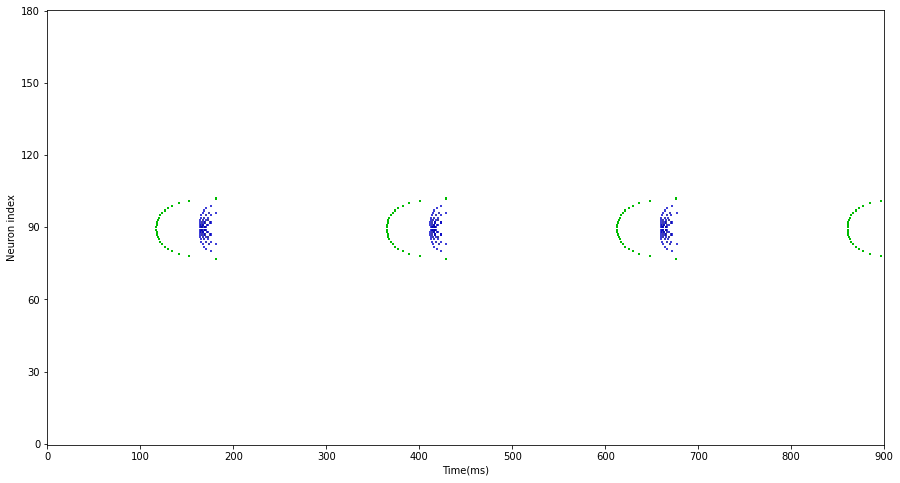

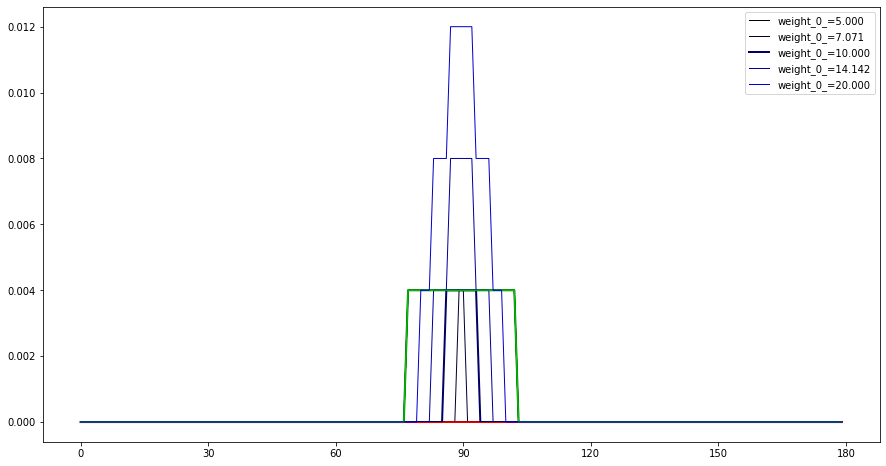

In [17]:
fig, ax = plt.subplots(figsize=figsize)
hfig, hax = plt.subplots(figsize=figsize)


for i_scan, weight_0_ in enumerate(weight_0*np.logspace(-1, 1, N_scan, base=2)):
    label = f'{weight_0_=:.3f}'
    print(label)

    weights, delays = tuned_delays(weight_0_)

    fig, ax, output = LSD_neuron(weights, delays, lambda_n=0, fig=fig, ax=ax, sat=i_scan/N_scan, alpha=1)#/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    

B_true_=0.250
B_true_=0.354
B_true_=0.500
B_true_=0.707
B_true_=1.000


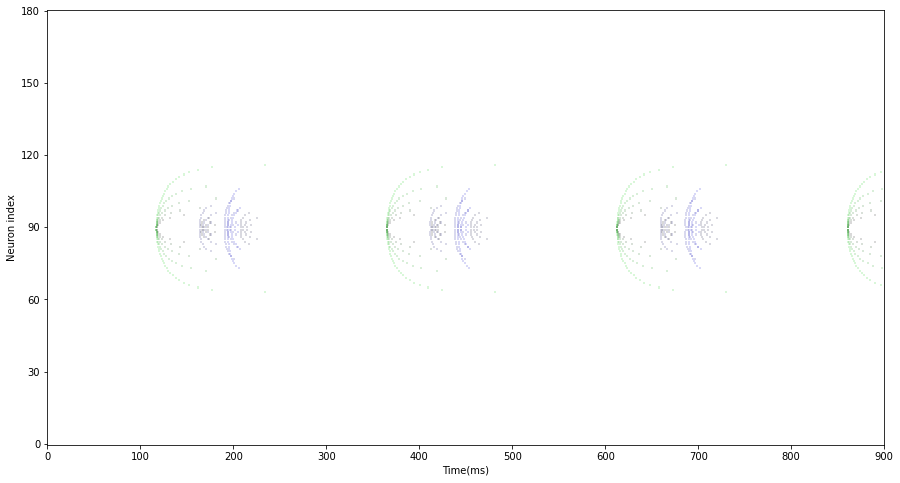

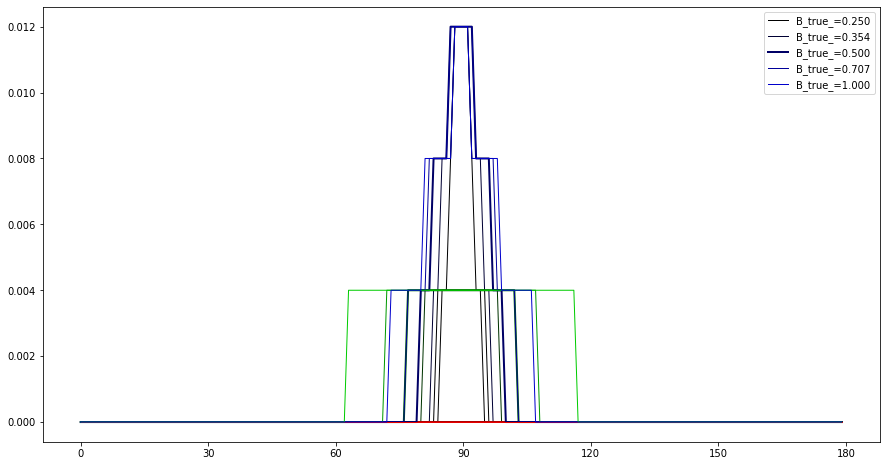

In [18]:
fig, ax = plt.subplots(figsize=figsize)
hfig, hax = plt.subplots(figsize=figsize)
for i_scan, B_true_ in enumerate(B_true*np.logspace(-1, 1, N_scan, base=2)):
    label = f'{B_true_=:.3f}'
    print(label)

    weights, delays = tuned_delays(weight_0, B=B_true_)
    
    fig, ax, output = LSD_neuron(weights, delays, lambda_n=0, B_true=B_true_, fig=fig, ax=ax, sat=i_scan/N_scan, alpha=1/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    


## adding hetero-synaptic delays and testing with noise

weight_0_=5.000
weight_0_=7.071
weight_0_=10.000
weight_0_=14.142
weight_0_=20.000


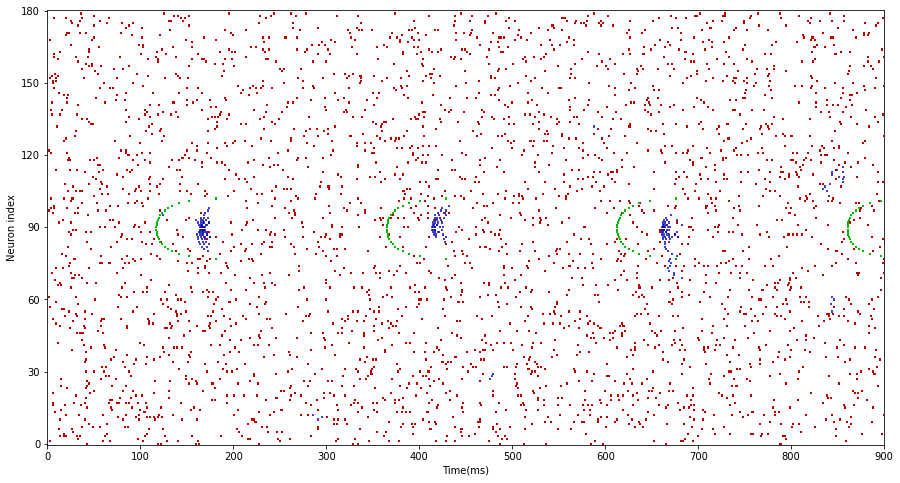

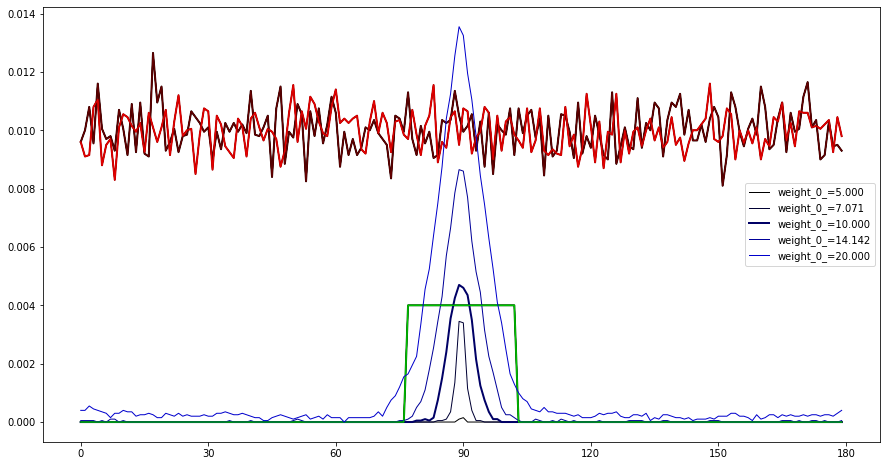

In [19]:
fig, ax = plt.subplots(figsize=figsize)
hfig, hax = plt.subplots(figsize=figsize)


for i_scan, weight_0_ in enumerate(weight_0*np.logspace(-1, 1, N_scan, base=2)):
    label = f'{weight_0_=:.3f}'
    print(label)

    weights, delays = tuned_delays(weight_0_)

    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan, alpha=1)#/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    

B_true_=0.250
TODO : 10.0
B_true_=0.354
TODO : 10.0
B_true_=0.500
TODO : 10.0
B_true_=0.707
TODO : 10.0
B_true_=1.000
TODO : 10.0


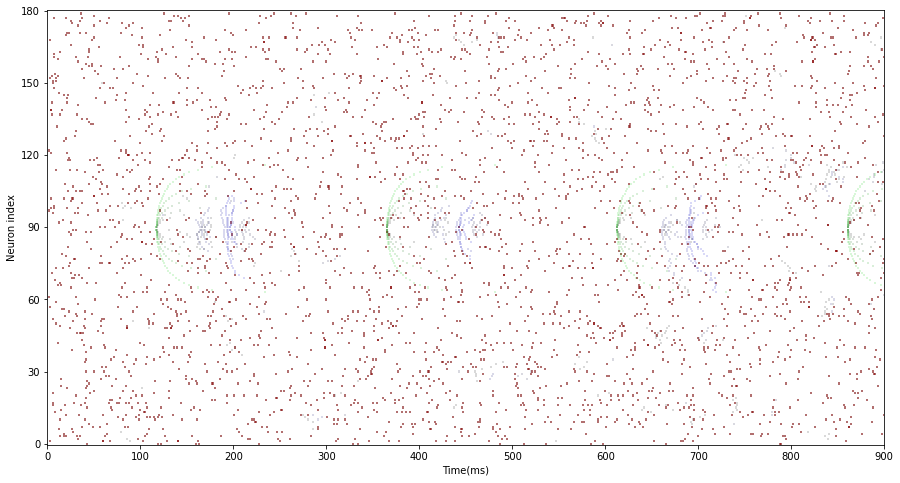

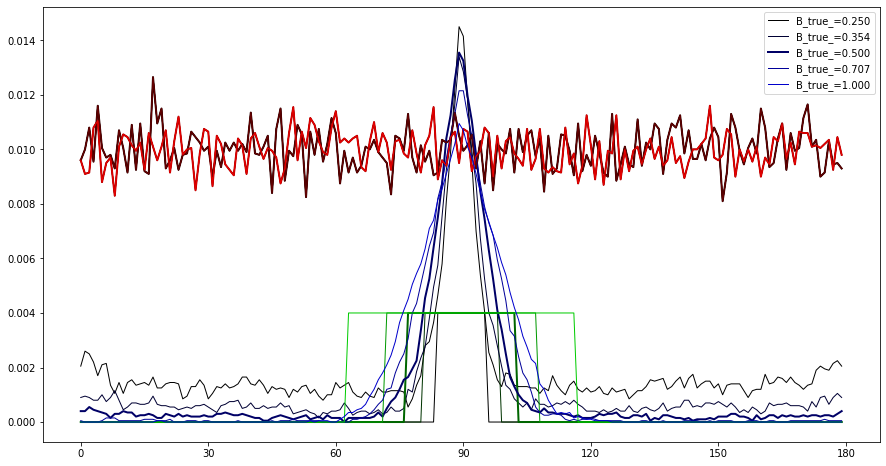

In [20]:
fig, ax = plt.subplots(figsize=figsize)
hfig, hax = plt.subplots(figsize=figsize)
for i_scan, B_true_ in enumerate(B_true*np.logspace(-1, 1, N_scan, base=2)):
    label = f'{B_true_=:.3f}'
    print(label)
    weights, delays = tuned_delays(weight_0, B=B_true_)
    
    fig, ax, output = LSD_neuron(weights, delays, B_true=B_true_, fig=fig, ax=ax, sat=i_scan/N_scan, alpha=1/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    

## As a  function  of noise lambda_n :

lambda_n_=2.500
lambda_n_=5.000
lambda_n_=10.000
lambda_n_=20.000
lambda_n_=40.000


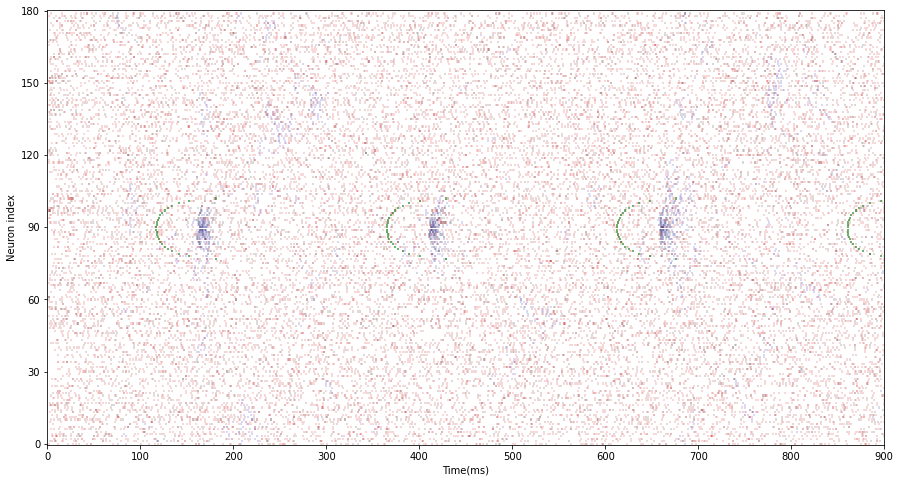

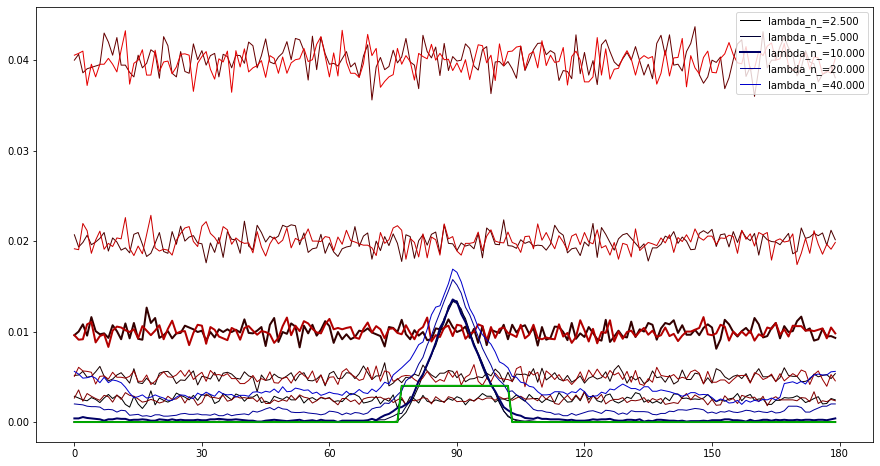

In [21]:
fig, ax = plt.subplots(figsize=figsize)
hfig, hax = plt.subplots(figsize=figsize)

for i_scan, lambda_n_ in enumerate(lambda_n*np.logspace(-1, 1, N_scan, base=4)):
    label = f'{lambda_n_=:.3f}'
    print(label)

    weights, delays = tuned_delays(weight_0)

    fig, ax, output = LSD_neuron(weights, delays, lambda_n=lambda_n_, fig=fig, ax=ax, sat=i_scan/N_scan, alpha=1/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    